#### Deep Learning

# Overfitting and underfitting
#### Francisco Maiocchi

***
### Introducción

En los ejemplos anteriores, vimos que la eficacia del modelo en validación llegaba a un pico durante el entrenamiento y luego comenzaba a empeorar. En otras palabras, el modelo estaba sufriendo overfitting del set de entrenamiento. Underfitting es lo opuesto a esto y sucede cuando todavía queda margen para mejorar el desempeño en el set de test. Esto puede suceder por distintas cosas, como por ejemplo que el modelo no sea lo suficientemente poderoso o que no fue entrenado lo suficiente.  

Si se sobreentrena se comienzan a aprender las particularidades del set de entrenamiento, por lo que es necesario llegar a un balance. Para prevenir overfitting, la mejor solución es usar más datos de entrenamiento. Idudablemente, cuanto más datos tengamos, nuestro modelo será capaz de generalizar mejor. Sin embargo, esto no es siempre posible y por esto surge la necesidad de utilizar técnicas de regularización. Esto genera limites en la cantidad y tipo de información que el modelo puede guardar. Si una red solo puede memorizar un grupo pequeño de patrones, el proceso de optimización lo va a forzar a aprender los patrones más importantes, lo que lo llevará a generalizar mejor.  

En este notebook veremos dos técnicas bastante comunes:  
+ Weight regularization
+ Dropuot  


Y se usarán para mejorar el clasificador de reseñas de IMDB

Utiliza KERAS que es la API de alto nivel de TensorFlow. Este ejemplo está en web oficial de TensorFlow en https://www.tensorflow.org/tutorials/keras/overfit_and_underfit?hl=es 

***
### Imports

In [2]:
# Importo TensorFlow como tf
import tensorflow as tf
# Importo keras
from tensorflow import keras

# Librerias auxiliares
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

1.12.0


***
### Descargo el dataset de IMDB
En vez de utilizar embedding como en el ejemplo anterior, aca vamos a utilizar multi-hot para encodear las oraciones. Este modelo va a llegar al overfit muy rapidamente. Se va a utilizar para demostrar cuando ocurre y como combatirlo.  

Multi-hot-encoding significa transformar nuestras listas en vectores de 0s o 1s. Por ejemplo, las secuencia [3, 5] se transforma en un array de tamaño 10000 de todos ceros, excepto las posiciones 3 y 5 que son 1.

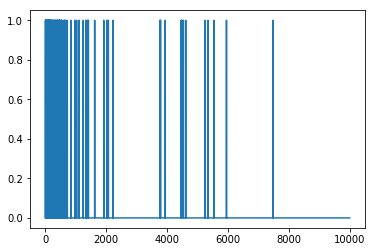

In [3]:
NUM_WORDS = 10000

(train_data, train_labels), (test_data, test_labels) = keras.datasets.imdb.load_data(num_words=NUM_WORDS)

def multi_hot_sequences(sequences, dimension):
    # Create an all-zero matrix of shape (len(sequences), dimension)
    results = np.zeros((len(sequences), dimension))
    for i, word_indices in enumerate(sequences):
        results[i, word_indices] = 1.0  # set specific indices of results[i] to 1s
    return results


train_data = multi_hot_sequences(train_data, dimension=NUM_WORDS)
test_data = multi_hot_sequences(test_data, dimension=NUM_WORDS)

plt.plot(train_data[0])

***
### Demostración de overfitting

La manera más sencilla de prevenir el overfitting es reduciendo el tamaño del modelo (número de parametros para aprender que depende de la cantidad de capas y neuronas). En Deep Learning, la cantidad de parametros del modeo se suele llamar capacidad del modelo. Un modelo con más parametros tendrá capacidad para memorizar más cosas y por lo tanto será capaz de aprender un mapeo estilo diccionario entre los datos del entrenamiento y el resultado esperado.  

Siempre hay que tener en cuenta que los métodos de Deep Learning siempre son buenos para aprender el set de entrenamiento, pero lo importante es que generalize para casos no vistos.  

Por otro lado, si la red tiene capacidades limitadas, no será capaz de aprender el mapeo tan facil. Para minimizar esta pérdida, deberá aprender representaciones que tengan un poder de predicción mayor. Hay que lograr un balance entre muchos parametros y pocos parametros.  

Desafortunadamente, no existe una fórmula mágica para determinar el tamaño ideal de la arquitectura. Se debe probar distintas alternativas empiricamente.  

Para encontrar un tamaño adecuado de modelo, es mejor arrancar con relativamente pocas capas y parametros y luego ir aumentando el tamaño de las capas, o agregando más capas, hasta que veamos que la validation loss no mejora. Vamos a probar esta metodologia con la red clasificadore de reseñas de pelicula.

Vamos a utilizar un modelo simple, usando solo Dense layers como base, y luego crearemos versiones más chicas y más grandes para comparar.

#### Baseline Model

In [4]:
baseline_model = keras.Sequential([
    # `input_shape` is only required here so that `.summary` works. 
    keras.layers.Dense(16, activation=tf.nn.relu, input_shape=(NUM_WORDS,)),
    keras.layers.Dense(16, activation=tf.nn.relu),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

baseline_model.compile(optimizer='adam',
                       loss='binary_crossentropy',
                       metrics=['accuracy', 'binary_crossentropy'])

baseline_model.summary()

baseline_history = baseline_model.fit(train_data,
                                      train_labels,
                                      epochs=20,
                                      batch_size=512,
                                      validation_data=(test_data, test_labels),
                                      verbose=2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                160016    
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 160,305
Trainable params: 160,305
Non-trainable params: 0
_________________________________________________________________
Train on 25000 samples, validate on 25000 samples
Epoch 1/20
 - 11s - loss: 0.4808 - acc: 0.8108 - binary_crossentropy: 0.4808 - val_loss: 0.3331 - val_acc: 0.8751 - val_binary_crossentropy: 0.3331
Epoch 2/20
 - 9s - loss: 0.2467 - acc: 0.9109 - binary_crossentropy: 0.2467 - val_loss: 0.2842 - val_acc: 0.8873 - val_binary_crossentropy: 0.2842
Epoch 3/20
 - 7s - loss: 0.1805 - acc: 0.9371 - binary_

#### Modelo pequeño

In [5]:
smaller_model = keras.Sequential([
    keras.layers.Dense(4, activation=tf.nn.relu, input_shape=(NUM_WORDS,)),
    keras.layers.Dense(4, activation=tf.nn.relu),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

smaller_model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy', 'binary_crossentropy'])

smaller_model.summary()

smaller_history = smaller_model.fit(train_data,
                                    train_labels,
                                    epochs=20,
                                    batch_size=512,
                                    validation_data=(test_data, test_labels),
                                    verbose=2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 4)                 40004     
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 5         
Total params: 40,029
Trainable params: 40,029
Non-trainable params: 0
_________________________________________________________________
Train on 25000 samples, validate on 25000 samples
Epoch 1/20
 - 9s - loss: 0.6790 - acc: 0.5936 - binary_crossentropy: 0.6790 - val_loss: 0.6540 - val_acc: 0.6609 - val_binary_crossentropy: 0.6540
Epoch 2/20
 - 8s - loss: 0.6140 - acc: 0.7220 - binary_crossentropy: 0.6140 - val_loss: 0.5867 - val_acc: 0.7683 - val_binary_crossentropy: 0.5867
Epoch 3/20
 - 8s - loss: 0.5274 - acc: 0.8212 - binary_cro

#### Modelo grande

In [6]:
bigger_model = keras.models.Sequential([
    keras.layers.Dense(512, activation=tf.nn.relu, input_shape=(NUM_WORDS,)),
    keras.layers.Dense(512, activation=tf.nn.relu),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

bigger_model.compile(optimizer='adam',
                     loss='binary_crossentropy',
                     metrics=['accuracy','binary_crossentropy'])

bigger_model.summary()

bigger_history = bigger_model.fit(train_data, train_labels,
                                  epochs=20,
                                  batch_size=512,
                                  validation_data=(test_data, test_labels),
                                  verbose=2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 512)               5120512   
_________________________________________________________________
dense_7 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 513       
Total params: 5,383,681
Trainable params: 5,383,681
Non-trainable params: 0
_________________________________________________________________
Train on 25000 samples, validate on 25000 samples
Epoch 1/20
 - 32s - loss: 0.3480 - acc: 0.8504 - binary_crossentropy: 0.3480 - val_loss: 0.2963 - val_acc: 0.8802 - val_binary_crossentropy: 0.2963
Epoch 2/20
 - 30s - loss: 0.1454 - acc: 0.9467 - binary_crossentropy: 0.1454 - val_loss: 0.3565 - val_acc: 0.8643 - val_binary_crossentropy: 0.3565
Epoch 3/20
 - 31s - loss: 0.0529 - acc: 0.9840 - b

#### Graficamos los resultados
Las lineas solidas muestran el training loss y las punteadas el validation loss (una validation loss menor representa un mejor modelo). Vemos que la red pequeña comienza el overfitting más tarde que el baseline y su performance decrece mucho más lento.

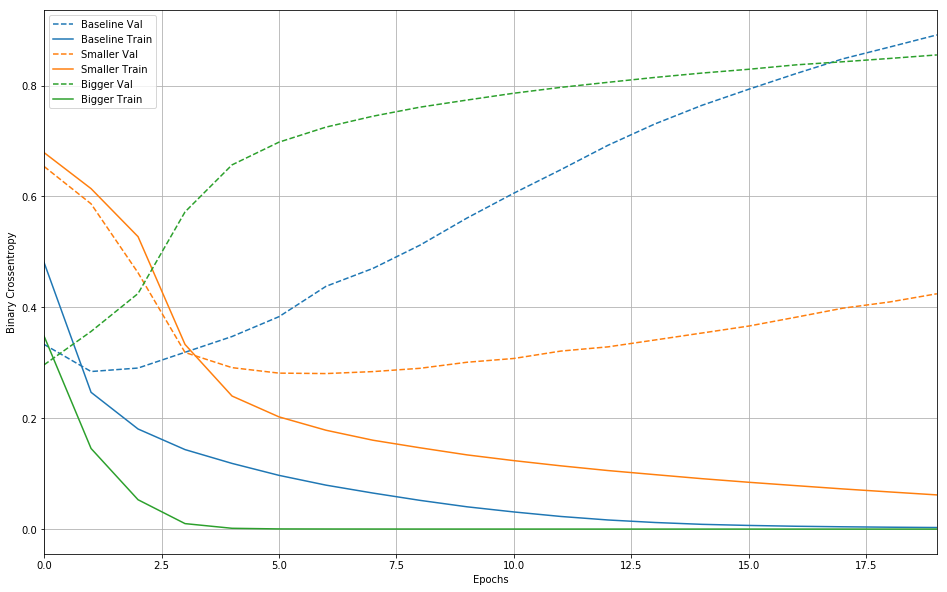

In [7]:
def plot_history(histories, key='binary_crossentropy'):
    plt.figure(figsize=(16,10))

    for name, history in histories:
        val = plt.plot(history.epoch, history.history['val_'+key],
                   '--', label=name.title()+' Val')
        plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
             label=name.title()+' Train')

    plt.xlabel('Epochs')
    plt.ylabel(key.replace('_',' ').title())
    plt.grid()
    plt.legend()

    plt.xlim([0,max(history.epoch)])


plot_history([('baseline', baseline_history),
              ('smaller', smaller_history),
              ('bigger', bigger_history)])

Podemos ver como la red grande comienza el overfitting casi al inicio del entrenamiento y empeora su performance más gravemente. 

***
### Estrategrias
#### Añadir weight regularization
Se suele decir que teniendo dos explicaciones de algo, la más simple (asume menos cosas) suele ser la correcta. Esto también aplica a los modelo aprendidos por redes neuronales. Dado un set de entrenamiento y una arquitectura de red, hay distintos set de pesos (multiples modelo) que pueden explicar los datos, y modelos simples que son menos probables de sufrir overfitting que los complejos.  

Un modelo simple, en este caso, es aquel donde la distribución los valores de los parametros tiene menos entropía (o un modelo con menos parametros juntos). Por esto, un buen método para evitar el overfitting es poner restricciones a la complejidad de la red forzando a que los pesos tengan valores pequeños, lo que hace que las distribución de pesos sea más regular. Esto se llama weight regularization, y es realizado añadiendo un costo asociado a pesos grande a la function loss de la red. Este costo puede ser de dos formas:  

+ L1 regularization: el costo añadido es proporcional al valor absoluto de los pesos.
+ L2 regularization: el costo añadido es proporcional al cuadrado de los pesos. Este método también es llamado weight decay.

En tf.keras, el weight regularization se implementa modificando el parametro de kernel_regularizer de cada capa. Vamos a usar L2 regularization.

In [8]:
l2_model = keras.models.Sequential([
    keras.layers.Dense(16, kernel_regularizer=keras.regularizers.l2(0.001),
                       activation=tf.nn.relu, input_shape=(NUM_WORDS,)),
    keras.layers.Dense(16, kernel_regularizer=keras.regularizers.l2(0.001),
                       activation=tf.nn.relu),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

l2_model.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=['accuracy', 'binary_crossentropy'])

l2_model_history = l2_model.fit(train_data, train_labels,
                                epochs=20,
                                batch_size=512,
                                validation_data=(test_data, test_labels),
                                verbose=2)

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
 - 9s - loss: 0.5279 - acc: 0.8018 - binary_crossentropy: 0.4890 - val_loss: 0.3766 - val_acc: 0.8746 - val_binary_crossentropy: 0.3370
Epoch 2/20
 - 8s - loss: 0.2976 - acc: 0.9100 - binary_crossentropy: 0.2545 - val_loss: 0.3302 - val_acc: 0.8882 - val_binary_crossentropy: 0.2844
Epoch 3/20
 - 8s - loss: 0.2450 - acc: 0.9316 - binary_crossentropy: 0.1970 - val_loss: 0.3345 - val_acc: 0.8852 - val_binary_crossentropy: 0.2847
Epoch 4/20
 - 8s - loss: 0.2199 - acc: 0.9424 - binary_crossentropy: 0.1686 - val_loss: 0.3473 - val_acc: 0.8825 - val_binary_crossentropy: 0.2948
Epoch 5/20
 - 8s - loss: 0.2067 - acc: 0.9492 - binary_crossentropy: 0.1527 - val_loss: 0.3610 - val_acc: 0.8794 - val_binary_crossentropy: 0.3061
Epoch 6/20
 - 8s - loss: 0.1936 - acc: 0.9538 - binary_crossentropy: 0.1380 - val_loss: 0.3770 - val_acc: 0.8756 - val_binary_crossentropy: 0.3208
Epoch 7/20
 - 8s - loss: 0.1867 - acc: 0.9574 - binary_crossentropy:

12(0.001) significa que cada coeficiente de la matriz pesos de la capa sumará 0.001 * weight_coefficeint_value^2 al total de la function loss de la red.

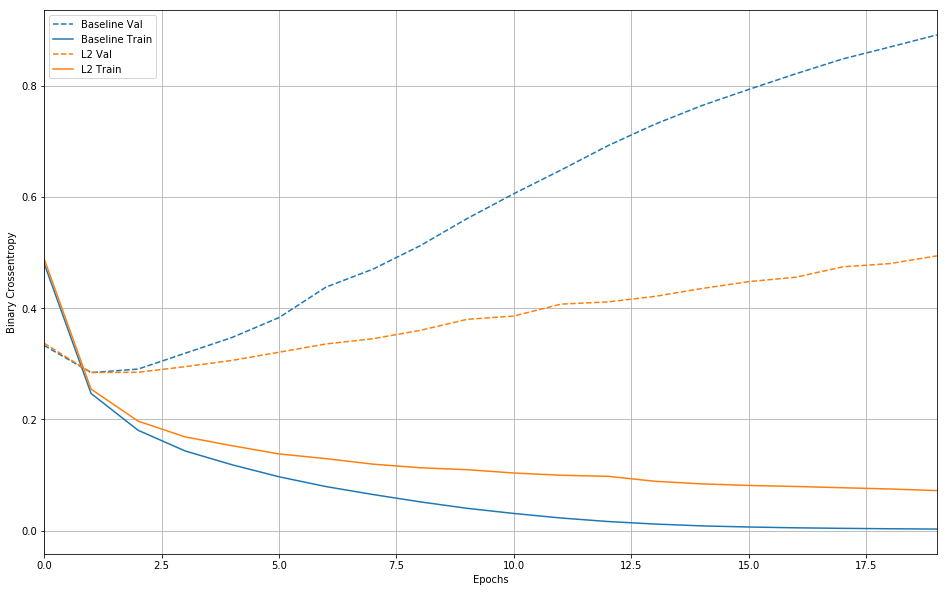

In [9]:
plot_history([('baseline', baseline_history),
              ('l2', l2_model_history)])

Como se puede ver, con L2 regularization el modelo se volvió mucho mas resistente al overfitting y tienen la misma cantidad de parametros.

***
### Añadir dropout
Dropout es una de las técnicas mas eficacez y comunes para evitar el overfitting. Si se aplica a una capa, consiste en aleatoriamente setear a 0 un cierto número de feautures de salida durante el entrenamiento. Por ejemplo, si una capa normalmente hubiera develto un vector [0.2, 0.5, 1.3, 0.8, 1.1] para una determinada entrada, luego de aplicar dropout, este vector de salida quedaría con algunos valores en cero [0, 0.5, 1.3, 0, 1.1]. EL dropout rate es la fracción de los feautures que se ponen en cero. Generalmente se setea entre 0.2 y 0.5. Durante el test, no se aplica el dropped out para balancear el hecho de que mas unidades estan activas que el tiempo de entrenamiento.  

En tf.keras se puede introducir dropout mediante una capa especial llamada dropout layer que actua sobre la capa anterior. Vamos a añadir dos capas de estas en nuestra red anterior.

In [10]:
dpt_model = keras.models.Sequential([
    keras.layers.Dense(16, activation=tf.nn.relu, input_shape=(NUM_WORDS,)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(16, activation=tf.nn.relu),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

dpt_model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy','binary_crossentropy'])

dpt_model_history = dpt_model.fit(train_data, train_labels,
                                  epochs=20,
                                  batch_size=512,
                                  validation_data=(test_data, test_labels),
                                  verbose=2)

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
 - 9s - loss: 0.6310 - acc: 0.6375 - binary_crossentropy: 0.6310 - val_loss: 0.5193 - val_acc: 0.8510 - val_binary_crossentropy: 0.5193
Epoch 2/20
 - 8s - loss: 0.4828 - acc: 0.7903 - binary_crossentropy: 0.4828 - val_loss: 0.3570 - val_acc: 0.8789 - val_binary_crossentropy: 0.3570
Epoch 3/20
 - 8s - loss: 0.3666 - acc: 0.8624 - binary_crossentropy: 0.3666 - val_loss: 0.2937 - val_acc: 0.8860 - val_binary_crossentropy: 0.2937
Epoch 4/20
 - 8s - loss: 0.2994 - acc: 0.8888 - binary_crossentropy: 0.2994 - val_loss: 0.2736 - val_acc: 0.8892 - val_binary_crossentropy: 0.2736
Epoch 5/20
 - 8s - loss: 0.2552 - acc: 0.9066 - binary_crossentropy: 0.2552 - val_loss: 0.2724 - val_acc: 0.8897 - val_binary_crossentropy: 0.2724
Epoch 6/20
 - 7s - loss: 0.2240 - acc: 0.9193 - binary_crossentropy: 0.2240 - val_loss: 0.2789 - val_acc: 0.8872 - val_binary_crossentropy: 0.2789
Epoch 7/20
 - 6s - loss: 0.1966 - acc: 0.9370 - binary_crossentropy:

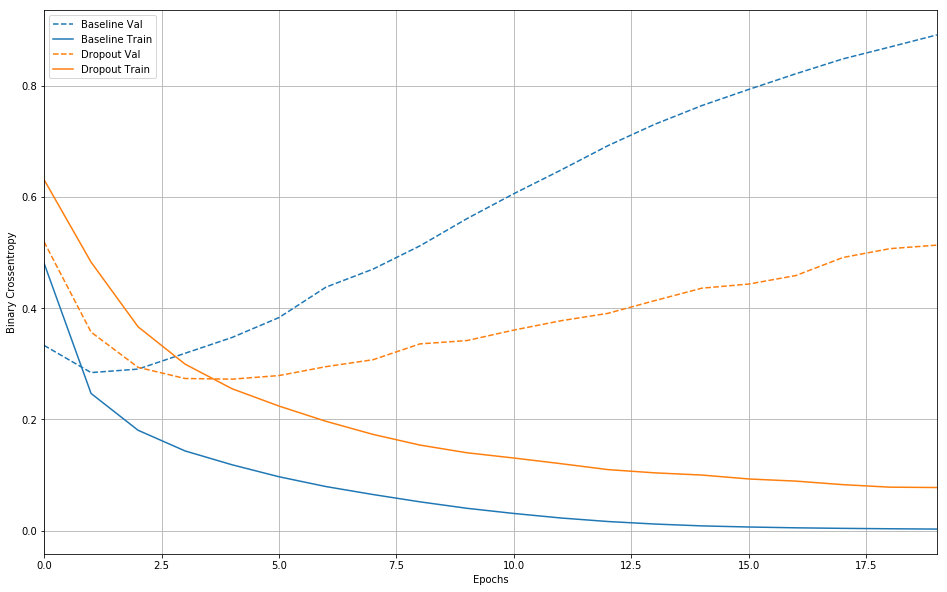

In [11]:
plot_history([('baseline', baseline_history),
              ('dropout', dpt_model_history)])

El uso de dropout mejora notablemente la resistencia al overfitting.  

Resumiendo, estas son las formas más comunes para prevenir el overfitting:  

+ Usar mas datos de entrenamiento (la mejor pero no siempre posible).
+ Reducir la capacidad de la red.
+ Weight regularization.
+ Dropout.

Hay dos enfoques importantes no vistos en este notebook que son **data-augmentation** y **batch normalization**